In [102]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import spatial
import glob
import math

%matplotlib inline

try:
    code_dir
except NameError:
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local", "")
    root_dir = "/".join(base_dir.split("/")[:-1])
base_dir

'/media/pipkin/ROCKET-PRO/CD8_DEV_SC/5_Chd7_RNA_meta'

In [103]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

def compile_log2fc(de_file_list, pval_cutoff=0.05, basemean_cutoff=50):
    print([x.split("/")[-1] for x in de_file_list])
    ###----- Compile log2fc dataframe
    df = pd.read_csv(de_file_list[0], index_col=0)
    df.index = [str(x).replace('\t', '') for x in df.index]
    de_log2fc_df = pd.DataFrame({'gene_name': [x for x in df.index if str(x) != 'nan']}).set_index('gene_name')

    for file in de_file_list:
        cp_type = file.split("/")[-1].split("---")[0].replace("WangDapeng_","")
        cp_type = cp_type.replace("-Salmon","").replace("_gn","").replace(".csv", "")

        df = pd.read_csv(file, index_col=0)
        df.index = [str(x).replace('\t', '') for x in df.index]
        df = df[df['pvalue'] < pval_cutoff]
        df = df[df['baseMean'] > basemean_cutoff]
        df = df[['log2FoldChange']]
        # df['log2FoldChange'] = (sigmoid(2**df['log2FoldChange']) - 0.5)*2
        df.columns = [cp_type]

        de_log2fc_df = de_log2fc_df.join(df, how='left')
    de_log2fc_df = de_log2fc_df.fillna(0)
    print(de_log2fc_df.head())
    print(de_log2fc_df.shape)
    return(de_log2fc_df)

In [104]:
###----- Chd7KO versus WT deseq
Chd7KO_de_dir = root_dir + '/5_Chd7_KO_RNA/0_salmon_DE_out/2_DEseq/gene_name'
conds = ['48h','EE','DP','MP','TE']
Chd7KO_v_ctrl_files = ["%s/KO_%s-WT_%s-Salmon_gn.csv"%(Chd7KO_de_dir, i, i) for i in conds]

Chd7KO_v_ctrl_log2fc_df = compile_log2fc(Chd7KO_v_ctrl_files)

###----- Chd7 RNAi
Chd7RNAi_de_dir = root_dir + '/5_Chd7_shRNA_RNA/1_DEseq2'
Chd7RNAi_v_ctrl_files = [x for x in glob.glob("%s/*gn.csv"%Chd7RNAi_de_dir) if "_vs_Ctrl" in x]

Chd7RNAi_v_ctrl_log2fc_df = compile_log2fc(Chd7RNAi_v_ctrl_files)

###----- Il2raKO Nascent
Il2rako_nascent_de_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/2_IL2RAKO_Nascent/3_DEseq2'

conds = ['6h','24h','48h']
Il2rako_nascent_files = ["%s/WT_%s_vs_KO_%s.csv"%(Il2rako_nascent_de_dir, i, i) for i in conds]
il2rako_v_wt_nascent_log2fc_df = - compile_log2fc(Il2rako_nascent_files)

###----- Brg1 versus control deseq
brg1_deseq_dir = root_dir + '/4_Runx3_Brg1_Meta/1_Brg1_RNA'
brg1_v_ctrl_files = glob.glob("%s/*gn.csv"%brg1_deseq_dir)
brg1_v_ctrl_files = [x for x in brg1_v_ctrl_files if "shCd19" in x]

brg1_v_ctrl_log2fc_df = compile_log2fc(brg1_v_ctrl_files)

###----- Runx3KO versus WT deseq
runx3_deseq_dir = root_dir + '/4_Runx3_Brg1_Meta/1_Runx3KO_RNA/DEseq2'
runx3_v_ctrl_files = glob.glob("%s/*gn.csv"%runx3_deseq_dir)

runx3_v_ctrl_log2fc_df = compile_log2fc(runx3_v_ctrl_files)

['KO_48h-WT_48h-Salmon_gn.csv', 'KO_EE-WT_EE-Salmon_gn.csv', 'KO_DP-WT_DP-Salmon_gn.csv', 'KO_MP-WT_MP-Salmon_gn.csv', 'KO_TE-WT_TE-Salmon_gn.csv']
               KO_48h-WT_48h  KO_EE-WT_EE  KO_DP-WT_DP  KO_MP-WT_MP  \
0610009B22Rik            0.0          0.0          0.0          0.0   
0610010F05Rik            0.0          0.0          0.0          0.0   
0610010K14Rik            0.0          0.0          0.0          0.0   
0610012G03Rik            0.0          0.0          0.0          0.0   
0610030E20Rik            0.0          0.0          0.0          0.0   

               KO_TE-WT_TE  
0610009B22Rik          0.0  
0610010F05Rik          0.0  
0610010K14Rik          0.0  
0610012G03Rik          0.0  
0610030E20Rik          0.0  
(34029, 5)
['Chd7_1_vs_Ctrl_gn.csv', 'Chd7_2_vs_Ctrl_gn.csv', 'Chd7_3_vs_Ctrl_gn.csv']
               Chd7_1_vs_Ctrl  Chd7_2_vs_Ctrl  Chd7_3_vs_Ctrl
0610009B22Rik             0.0             0.0             0.0
0610010F05Rik             0.0           

## Compile

In [105]:
all_dfs = {"Chd7KO":Chd7KO_v_ctrl_log2fc_df, "Chd7RNAi":Chd7RNAi_v_ctrl_log2fc_df,
           "Il2raKO_nascent": il2rako_v_wt_nascent_log2fc_df, "Brg1RNAi":brg1_v_ctrl_log2fc_df
          }
          # "Runx3KO":runx3_v_ctrl_log2fc_df, 
          # 

In [106]:
all_genes = set()
for keys, df in all_dfs.items():
    all_genes = all_genes.union(set(df.index))
all_genes = [x for x in all_genes if str(x) != 'nan']

In [107]:
compiled_df = pd.DataFrame({"gene_name": all_genes}).set_index("gene_name")
for keys, df in all_dfs.items():
    df_newkey = df.copy()
    df_newkey.columns = [keys+"|"+x for x in df_newkey.columns]
    compiled_df = compiled_df.join(df_newkey, how='left')


In [108]:
compiled_df = compiled_df.fillna(0)
compiled_df['Ctrl|WT'] = [0 for x in range(len(compiled_df))]
compiled_df_rowabsmax = compiled_df.abs().max(axis=1)
compiled_df_rowabssum = compiled_df.abs().sum(axis=1)

compiled_df_sqrt = np.sqrt(compiled_df.abs()) * compiled_df.abs() / compiled_df
compiled_df_sqrt = compiled_df_sqrt.fillna(0)

compiled_slt_df = compiled_df[compiled_df_rowabsmax > 0.5]
compiled_slt_df.shape

(5331, 14)

In [109]:
pca = PCA(n_components=4)
pca.fit(compiled_slt_df)
X_new = pca.fit_transform(compiled_slt_df)

print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.24354793 0.20834343 0.20345461 0.06836387]


0.7237098336304413

In [110]:
pca.components_.shape

(4, 14)

In [111]:
pca_df = pd.DataFrame(pca.components_.T)
pca_df['exps'] = [x.split("|")[0] for x in compiled_df.columns]
pca_df['comparisons'] = compiled_df.columns
pca_df

,0,1,2,3,exps,comparisons
0,-0.002470,0.107326,0.240552,0.019216,Chd7KO,Chd7KO|KO_48h-WT_48h
1,0.002616,0.197003,0.412534,-0.001140,Chd7KO,Chd7KO|KO_EE-WT_EE
2,0.000614,0.189029,0.435134,-0.024594,Chd7KO,Chd7KO|KO_DP-WT_DP
3,0.013570,0.175753,0.424521,0.001136,Chd7KO,Chd7KO|KO_MP-WT_MP
4,-0.004061,0.225408,0.484214,-0.023153,Chd7KO,Chd7KO|KO_TE-WT_TE
5,-0.015391,0.001103,0.008072,0.009642,Chd7RNAi,Chd7RNAi|Chd7_1_vs_Ctrl
6,-0.000826,0.009483,0.004158,-0.009449,Chd7RNAi,Chd7RNAi|Chd7_2_vs_Ctrl
7,-0.009398,-0.000327,0.001899,0.003744,Chd7RNAi,Chd7RNAi|Chd7_3_vs_Ctrl
8,-0.032406,-0.222308,0.104061,0.029356,Il2raKO_nascent,Il2raKO_nascent|WT_6h_vs_KO_6h
9,-0.050967,-0.432907,0.188410,0.012497,Il2raKO_nascent,Il2raKO_nascent|WT_24h_vs_KO_24h


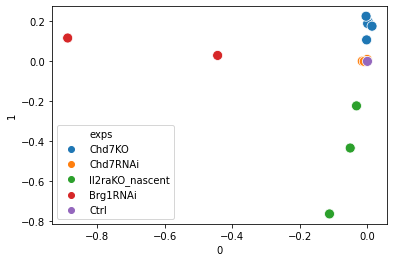

In [114]:
sns.scatterplot(data=pca_df, x=0, y=1, hue='exps', s=100)
plt.show()
plt.close()

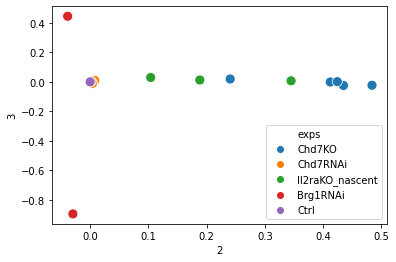

In [116]:
sns.scatterplot(data=pca_df, x=2, y=3, hue='exps', s=100)
plt.show()
plt.close()